In [ ]:
import findspark
findspark.init('c:\spark')

In [2]:
import pandas as pd
from pyspark.sql import SQLContext
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, ArrayType
from pyspark.sql import SparkSession
import multiprocessing 

In [3]:
sc =SparkContext()
sqlContext = SQLContext(sc)

In [4]:
df = sqlContext.read.csv('churn_csv.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [6]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [6]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
SeniorCitizen,7043,0.1621468124378816,0.3686116056100135,0,1
tenure,7043,32.37114865824223,24.559481023094442,0,72


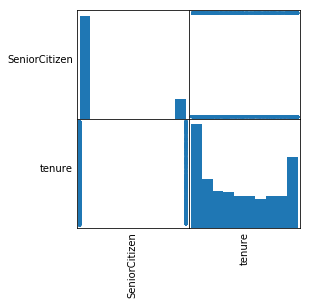

In [8]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(4, 4));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [9]:
df = df.select('gender','SeniorCitizen','Partner','Dependents','tenure', 'PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport', 'StreamingTV','StreamingMovies','Contract', 'PaperlessBilling','PaymentMethod','Churn')
cols = df.columns
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- Churn: string (nullable = true)



In [10]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['gender','Partner','Dependents', 'PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport', 'StreamingTV','StreamingMovies','Contract', 'PaperlessBilling','PaymentMethod']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'Churn', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['SeniorCitizen', 'tenure']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [11]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- Churn: string (nullable = true)



In [12]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,1,0,1
features,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ..."
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic


In [13]:
train, test = df.randomSplit([0.7, 0.3], seed = 2019)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 4891
Test Dataset Count: 2152


In [14]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

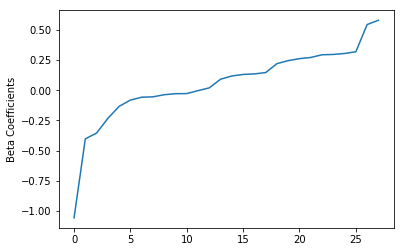

In [15]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

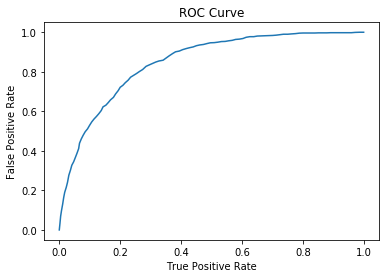

Training set areaUnderROC: 0.8470577664741992


In [16]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

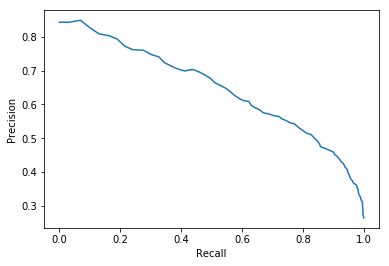

In [17]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [18]:
predictions = lrModel.transform(test)
predictions.select('gender', 'tenure', 'label', 'rawPrediction', 'prediction', 'probability').show(20)

+------+------+-----+--------------------+----------+--------------------+
|gender|tenure|label|       rawPrediction|prediction|         probability|
+------+------+-----+--------------------+----------+--------------------+
|  Male|     8|  0.0|[-0.7433430060219...|       1.0|[0.32227355335731...|
|  Male|     1|  0.0|[-0.6986656228177...|       1.0|[0.33210814279805...|
|  Male|    17|  0.0|[-0.1038072726826...|       1.0|[0.47407146136804...|
|  Male|     5|  0.0|[-0.5352473399948...|       1.0|[0.36929386306778...|
|  Male|     3|  0.0|[-0.3046767223733...|       1.0|[0.42441461950029...|
|  Male|    27|  0.0|[0.58761080282932...|       0.0|[0.64281676534653...|
|  Male|    16|  0.0|[0.12089009579689...|       0.0|[0.53018577061819...|
|  Male|    11|  0.0|[-0.0551461606587...|       1.0|[0.48621695262596...|
|  Male|     2|  0.0|[-0.0701223759322...|       1.0|[0.48247658586304...|
|  Male|     9|  0.0|[0.19012815225188...|       0.0|[0.54738936860063...|
|  Male|    10|  0.0|[0.2

In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8404942408699957
